In [38]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
from numpy import array 
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline


(10000, 1024)
[[  61.217   44.989   48.028 ...,  188.552  123.991   98.989]
 [ 171.263  133.597  103.273 ...,  136.674  137.603  137.244]
 [ 255.     253.     253.    ...,   82.679   82.978   83.978]
 ..., 
 [  71.444   62.433   77.231 ...,   74.523   76.708   78.067]
 [ 253.505  253.413  219.657 ...,  212.94   255.     254.299]
 [  51.621   51.322   50.909 ...,  180.979  180.979  181.093]]
(10000, 3072)
6
(10000,)
[6 9 9 ..., 1 1 5]
[255 253 255 ..., 209 218 247]
(10000, 32, 32, 3)
(10000, 10)
[[[ 221.  217.  223.]
  [ 227.  230.  233.]
  [ 233.  232.  230.]
  ..., 
  [ 225.  226.  226.]
  [ 226.  227.  226.]
  [ 225.  225.  226.]]

 [[ 207.  210.  212.]
  [ 215.  218.  217.]
  [ 219.  223.  223.]
  ..., 
  [ 199.  197.  194.]
  [ 194.  192.  185.]
  [ 183.  175.  131.]]

 [[ 185.  183.  186.]
  [ 190.  191.  189.]
  [ 186.  184.  185.]
  ..., 
  [  90.   86.   70.]
  [  61.   49.   44.]
  [  44.   48.   47.]]

 ..., 
 [[ 118.  115.  112.]
  [ 117.  115.  115.]
  [ 112.  109.  114.]
 

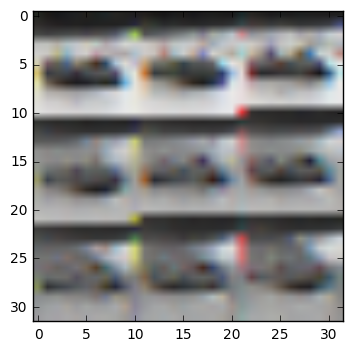

In [172]:
## this part is some test on the data file, show some picture in the data_batch_1 file, we can see it is a frog.
pickle_file = 'cifar-10-batches-py/train_folders/data_batch_1'  # index 0 should be all As, 1 = all Bs, etc.
with open(pickle_file, 'rb') as f:
    dic = pickle.load(f)  # unpickle
    data = dic['data']
    data_r = data[ :,0:1024]
    data_g = data[ :,1024:2048]
    data_b = data[ :,2048:3072]
    R = np.array(data_r)
    G = np.array(data_g)
    B = np.array(data_b)
    whole = (R*0.299+G*0.587+B*0.114)
    print(whole.shape)
    print(whole)
    print(data.shape)
    labels = dic['labels']
    labels_ny = np.ndarray(0, dtype=np.int32)
    #print(labels_ny.shape)
    for label in labels:
        labels_ny = np.append(labels_ny,label)
    #labels_ny = labels_ny.fromlist(labels)
    print(labels[0])
    print(labels_ny.shape)
    print(labels_ny)
    print(data[666, :])
    dataset = data.reshape(
    (-1,32,32,3)).astype(np.float32)
    print(dataset.shape)
    labels = (np.arange(10) == labels_ny[:,None]).astype(np.float32)
    print(labels.shape)
    #sample_idx = np.random.randint(len(letter_set))  # pick a random image index
    sample_image = dataset[2344, :, :]  # extract a 2D slice
    print(sample_image)
    #plt.figure()
    plt.imshow(sample_image)  # display it

In [120]:
train_folders=[]
train_folders.append('cifar-10-batches-py/train_folders/data_batch_1')
train_folders.append('cifar-10-batches-py/train_folders/data_batch_2')
train_folders.append('cifar-10-batches-py/train_folders/data_batch_3')
train_folders.append('cifar-10-batches-py/train_folders/data_batch_4')
train_folders.append('cifar-10-batches-py/train_folders/data_batch_5')
test_folders =[]
test_folders.append('cifar-10-batches-py/test_folders/test_batch')
print(train_folders)
print(test_folders)
train_datasets = train_folders
test_datasets = test_folders
print(test_datasets)
string='print(os.path.join(train_datasets[0]))'
print(string)

['cifar-10-batches-py/train_folders/data_batch_1', 'cifar-10-batches-py/train_folders/data_batch_2', 'cifar-10-batches-py/train_folders/data_batch_3', 'cifar-10-batches-py/train_folders/data_batch_4', 'cifar-10-batches-py/train_folders/data_batch_5']
['cifar-10-batches-py/test_folders/test_batch']
['cifar-10-batches-py/test_folders/test_batch']
print(os.path.join(train_datasets[0]))


In [167]:
img_size = 32
image_size = 32
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for pickle_file in pickle_files:       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's not shuffle the letters to have random validation and training set!!
        # np.random.shuffle(letter_set)
        data = letter_set['data']
        data_r = data[ :,0:1024]
        data_g = data[ :,1024:2048]
        data_b = data[ :,2048:3072]
        R = np.array(data_r)
        G = np.array(data_g)
        B = np.array(data_b)
        whole = (R*0.299+G*0.587+B*0.114)
        data = whole.reshape(
        (-1,32,32)).astype(np.float32)
        labels = letter_set['labels']
        labels_ny = np.ndarray(0, dtype=np.int32)
        #print(labels_ny.shape)
        for label in labels:
            labels_ny = np.append(labels_ny,label)
        if valid_dataset is not None:
          valid_letter = data[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = labels_ny[:vsize_per_class]
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = data[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = labels_ny[vsize_per_class:end_l]
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 45000
valid_size = 5000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (45000, 32, 32) (45000,)
Validation: (5000, 32, 32) (5000,)
Testing: (10000, 32, 32) (10000,)


In [168]:
pickle_file = 'cifar10.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
